In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from sklearn.model_selection import train_test_split

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.15.2'

In [2]:
# importing files
import zipfile
with zipfile.ZipFile('./trafficsigns_shapedata.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [4]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./trafficsigns_shapedata/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

In [5]:
data.label.unique()

array(['square', 'diamond', 'hex', 'triangle', 'round'], dtype=object)

In [6]:
data.shape

(3650, 2)

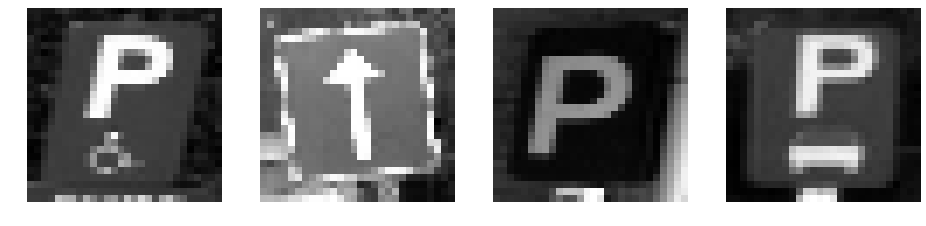

In [7]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [8]:
d = {'square':0, 'diamond':1, 'hex':2, 'triangle':3, 'round':4}
data['labels_num'] = data['label'].map(d, na_action='ignore')

In [9]:
data.columns

Index(['image_path', 'label', 'labels_num'], dtype='object')

In [10]:
trainData, validateData = train_test_split(data ,test_size=0.20, random_state=42)

In [11]:
trainData.shape

(2920, 3)

In [12]:
validateData.shape

(730, 3)

In [13]:
N_train_images = trainData.shape[0]
N_val_images = validateData.shape[0]

In [14]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [15]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

In [27]:
def train_model(model_, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2920 validated image filenames belonging to 5 classes.
Found 730 validated image filenames belonging to 5 classes.


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_7 (Activation)    (None, 9, 9, 64)         

In [30]:
res = train_model(model_cnn, num_epoch=30, verbose=True)

Training epoch 0: Loss = 1.3482410907745361, Accuracy = 0.46413934230804443
Validation epoch 0: Loss = 1.2878916937371958, Accuracy = 0.43885868787765503
Training epoch 1: Loss = 1.2868894338607788, Accuracy = 0.47617170214653015
Validation epoch 1: Loss = 1.2365825292856798, Accuracy = 0.4570651948451996
Training epoch 2: Loss = 1.2069071531295776, Accuracy = 0.5245901346206665
Validation epoch 2: Loss = 0.8204069830801176, Accuracy = 0.7217391729354858
Training epoch 3: Loss = 0.9773827195167542, Accuracy = 0.6409993767738342
Validation epoch 3: Loss = 0.6222348576006682, Accuracy = 0.7951087355613708
Training epoch 4: Loss = 0.86381995677948, Accuracy = 0.6876576542854309
Validation epoch 4: Loss = 0.4997729050076526, Accuracy = 0.835326075553894
Training epoch 5: Loss = 0.7269630432128906, Accuracy = 0.7492119073867798
Validation epoch 5: Loss = 0.3416071629718594, Accuracy = 0.914945662021637
Training epoch 6: Loss = 0.6368333697319031, Accuracy = 0.7908260226249695
Validation epo

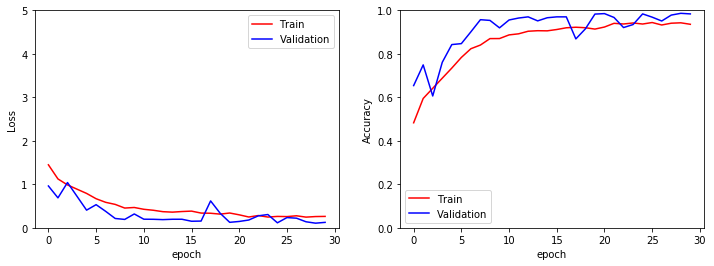

In [29]:
plot_results(res)

In [33]:
#Prediction below

In [31]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = train_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')



Found 730 validated image filenames belonging to 5 classes.


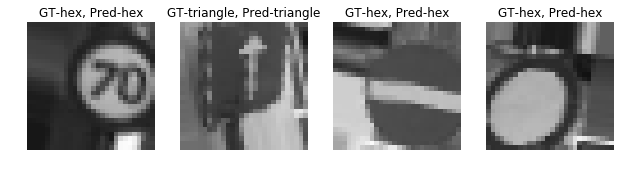

In [32]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [35]:
print("what")

what


In [36]:
print("NOoo")

NOoo
